# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [4]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

# Analysis for IMC

## Data reading

In [5]:
# parameters
_round_num = 3
_time_per_day = 1000000

In [6]:
def get_file_trades(day):
    fname = f"../data/round{_round_num}/trades_round_{_round_num}_day_{day}_nn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + price_df["day"] * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_symbol_trades(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        trade_df = get_file_trades(day)
        trade_df["day"] = day
        data += [trade_df]
    
    # concat
    trade_df = pd.concat(data)
    
    
    trade_df = trade_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        trade_df = trade_df[trade_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    trade_df["time"] = trade_df["time"] + trade_df["day"] * _time_per_day
    trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
    
    return trade_df

def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    symbols = set(price_df["symbol"])
    
    return price_df[["time", "symbol", "mid_price"]].rename({"mid_price": "mid"}, axis=1).copy()

In [7]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on="time")
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

In [8]:
def scatter_noise(x, y, xnoise=0.1, ynoise=0.1, s=0.1, label=None):
    xp = x + np.random.normal(scale=xnoise, size=len(x))
    yp = y + np.random.normal(scale=ynoise, size=len(y))
    
    plt.scatter(
        xp, yp, 
        s=s, 
        label=label,
    )

## Dolphin vs Gear - Leading indicator

fname ../data/round3/trades_round_3_day_0_nn.csv
fname ../data/round3/trades_round_3_day_1_nn.csv
fname ../data/round3/trades_round_3_day_2_nn.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/prices_round_3_day_2.csv
fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/prices_round_3_day_2.csv
model  
6.829 x + 7.852e+04


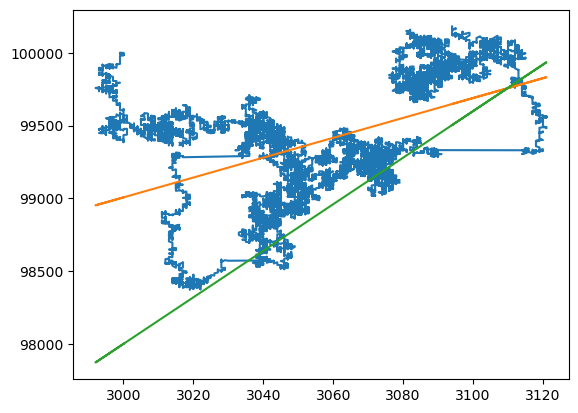

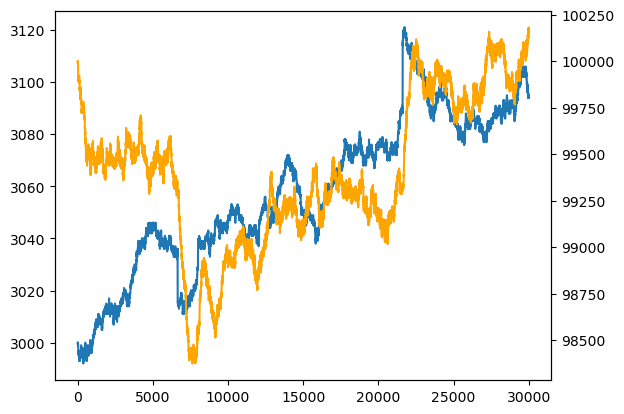

In [9]:
_day_range = [0, 1, 2]
# _day_range = [1, 2]

# get trade data for gear
trade_df = get_symbol_trades("DIVING_GEAR", _day_range)

# get gear data
gear_price_df = get_symbol_prices("DIVING_GEAR", _day_range)
gear_df = get_whale_quotes(gear_price_df)

# get dol data
dol_df = get_all_mids(_day_range)
dol_df = dol_df[dol_df["symbol"] == "DOLPHIN_SIGHTINGS"].reset_index(drop=True)

# combine into single dataframe
pair_df = gear_df[["time"]].copy()
pair_df["gear"] = gear_df["mid_price"]
pair_df["dol"] = dol_df["mid"]

# pair_df = pair_df.iloc[5000:].reset_index(drop=True)

# fit linreg to data
model = np.poly1d(np.polyfit(pair_df["dol"], pair_df["gear"], deg=1))
print("model", model)
plt.plot(pair_df["dol"], pair_df["gear"])
plt.plot(pair_df["dol"], model(pair_df["dol"]))
plt.plot(pair_df["dol"], 16 * pair_df["dol"] + 50000)
plt.show()


# plot dol/gear over time
ax = plt.gca()
ax.plot(pair_df["dol"])

ax2 = ax.twinx()
ax2.plot(pair_df["gear"], color="orange")
plt.show()

### dol / gear change histograms

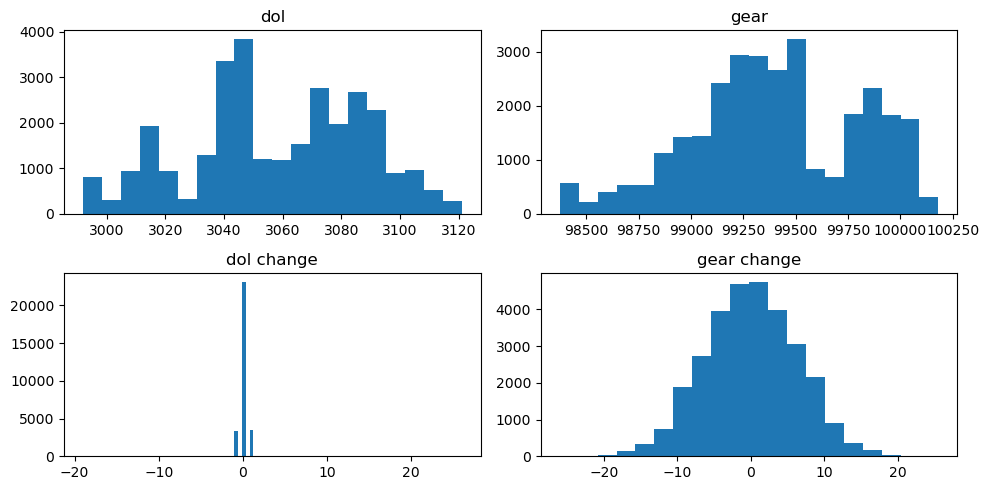

dol stats


,count,mean,std,min,25%,50%,75%,max
dol,29999.0,0.003133,0.52052,-19.0,0.0,0.0,0.0,26.0


gear stats


,count,mean,std,min,25%,50%,75%,max
gear,29999.0,0.005984,6.220134,-26.0,-4.0,0.0,4.0,25.5


In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(221)
plt.hist(pair_df["dol"], bins=20)
plt.title("dol")

plt.subplot(222)
plt.hist(pair_df["gear"], bins=20)
plt.title("gear")

plt.subplot(223)
plt.hist(pair_df["dol"].diff(1), bins=100)
plt.title("dol change")

plt.subplot(224)
plt.hist(pair_df["gear"].diff(1), bins=20)
plt.title("gear change")

plt.tight_layout()
plt.show()

# print stats
print("dol stats")
display(pair_df["dol"].diff(1).describe().to_frame().T)
print("gear stats")

display(pair_df["gear"].diff(1).describe().to_frame().T)

#### dol/gear change filtered


In [11]:
pair_df["dol_change"] = pair_df["dol"].diff(1) 

gear_change                                               
               count      mean       std   min  25%  50%  75%   max
dol_sign                                                           
-1.0          3400.0  0.002353  6.284996 -22.0 -4.0  0.0  4.0  25.5
 0.0         23138.0  0.029000  6.194313 -26.0 -4.0  0.0  4.0  22.5
 1.0          3461.0 -0.144322  6.327163 -20.5 -4.0  0.0  4.0  22.5

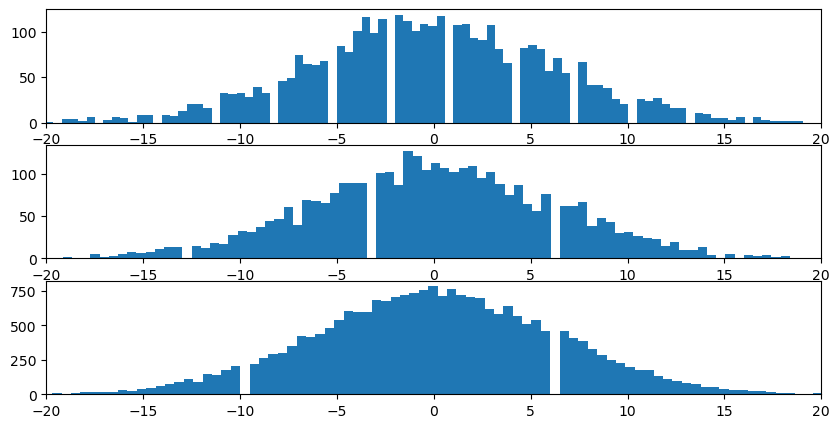

In [12]:
ups = pair_df["dol_change"] > 0
downs = pair_df["dol_change"] < 0
sames = pair_df["dol_change"] == 0

pair_df["dol_sign"] = np.sign(pair_df["dol_change"])
pair_df["gear_change"] = pair_df["gear"].diff(1)

plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.hist(pair_df["gear_change"][ups], bins=100)
plt.xlim(-20, 20)

plt.subplot(312)
plt.hist(pair_df["gear_change"][downs], bins=100)
plt.xlim(-20, 20)

plt.subplot(313)
plt.hist(pair_df["gear_change"][sames], bins=100)
plt.xlim(-20, 20)

pair_df.groupby("dol_sign")[["gear_change"]].describe()

### closer look into single event

In [13]:
change = pair_df["dol"].diff(25)
special = pair_df[change.abs() > 5].copy()
special["dol_change"] = change
display(special)

,time,gear,dol,dol_change,dol_sign,gear_change
3912,391200,99520.5,3034.0,6.0,1.0,-3.0
6641,664100,99283.0,3017.0,-17.0,-1.0,-8.5
6642,664200,99287.0,3017.0,-17.0,0.0,4.0
6643,664300,99286.5,3017.0,-16.0,0.0,-0.5
6644,664400,99288.0,3017.0,-16.0,0.0,1.5
...,...,...,...,...,...,...
23273,2327300,99880.0,3092.0,-6.0,-1.0,-3.0
23274,2327400,99885.0,3092.0,-6.0,0.0,5.0
23275,2327500,99882.0,3092.0,-6.0,0.0,-3.0
24176,2417600,99957.0,3095.0,-6.0,-1.0,6.0


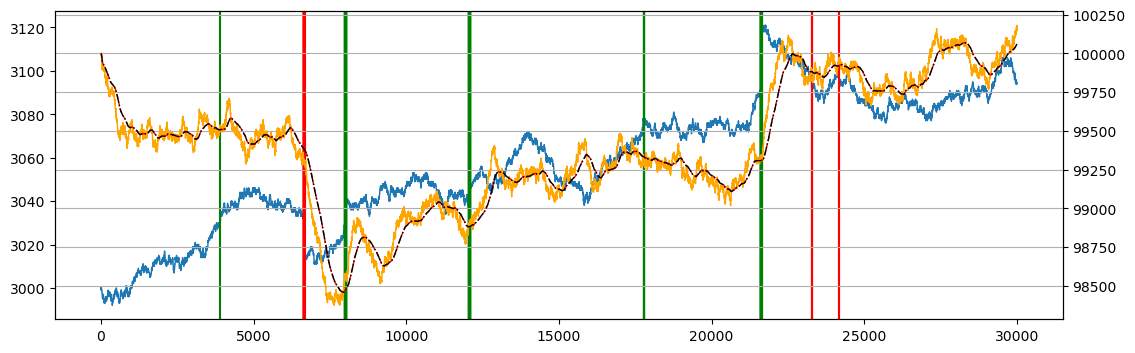

In [14]:
# all
plt.figure(figsize=(13, 4))
ax = plt.gca()
ax.plot(pair_df["dol"], linewidth=1)
# ax.plot(pair_df["dol"].ewm(span=200).mean(), linewidth=1, linestyle="--", marker=None, color="green")
ax2 = ax.twinx()
ax2.plot(pair_df["gear"], linewidth=1, color="orange")
ax2.plot(pair_df["gear"].ewm(span=500).mean(), linewidth=1, linestyle="--", marker=None, color="red")
ax2.plot(pair_df["gear"].ewm(span=500).mean(), linewidth=1, linestyle="-.", marker=None, color="black")

for x in special.index:
    if special.loc[x]["dol_change"] > 0:
        color = "green"
    else:
        color = "red"
    ax.axvline(x=x, color=color)

plt.grid()
plt.show()

In [15]:
pair_df["gear"]

0        100000.0
1        100000.0
2        100002.0
3        100000.0
4         99994.5
           ...   
29995    100174.5
29996    100171.0
29997    100179.5
29998    100182.0
29999    100179.5
Name: gear, Length: 30000, dtype: float64

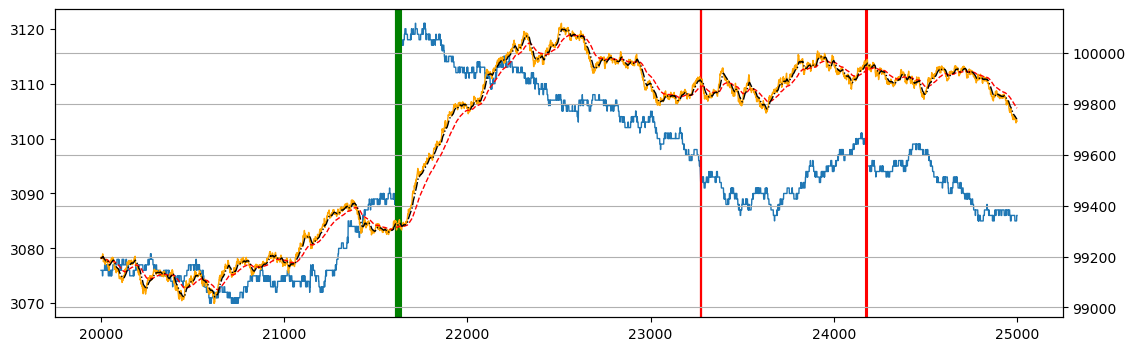

In [16]:
# closer look
df = pair_df.iloc[20000:25000]
# df = pair_df.iloc[5000:10000]
# all
plt.figure(figsize=(13, 4))
ax = plt.gca()
ax.plot(df["dol"], linewidth=1)
# ax.plot(pair_df["dol"].ewm(span=200).mean(), linewidth=1, linestyle="--", marker=None, color="green")
ax2 = ax.twinx()
ax2.plot(df["gear"], linewidth=1, color="orange")
ax2.plot(df["gear"].ewm(span=100).mean(), linewidth=1, linestyle="--", marker=None, color="red")
ax2.plot(df["gear"].ewm(span=21).mean(), linewidth=1, linestyle="-.", marker=None, color="black")

for x in special.index:
    if x not in df.index:
        continue
    if special.loc[x]["dol_change"] > 0:
        color = "green"
    else:
        color = "red"
    ax.axvline(x=x, color=color)

plt.grid()
plt.show()

### closer look into single event

In [17]:
pair_df[pair_df["dol"].diff(1).abs() > 5]

,time,gear,dol,dol_change,dol_sign,gear_change
6641,664100,99283.0,3017.0,-19.0,-1.0,-8.5
7997,799700,98573.0,3039.0,9.0,1.0,1.5
12057,1205700,98878.0,3046.0,8.0,1.0,-7.5
21611,2161100,99331.0,3114.0,26.0,1.0,-1.0


### Gear Change Moving Average

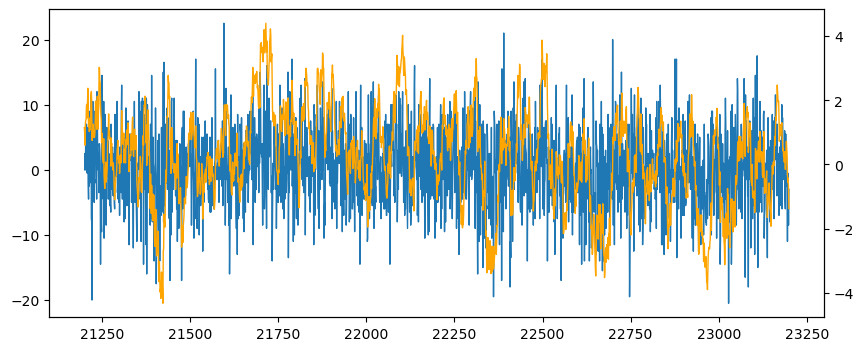

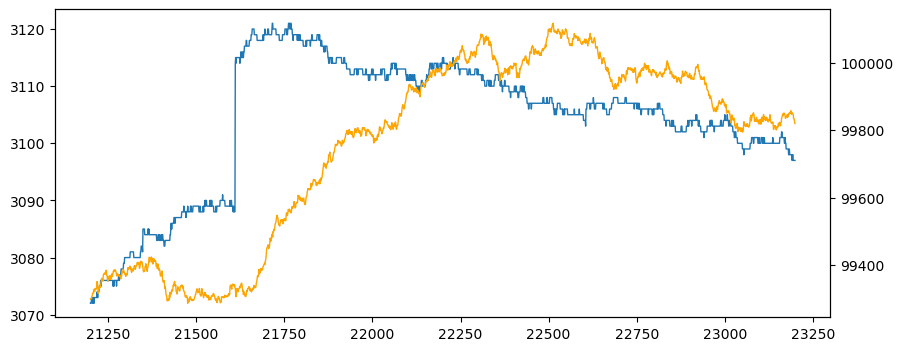

In [18]:
lb, offset = 21200, 2000
ub = lb + offset

df = pair_df.iloc[lb:ub]

diff = df["gear"].diff(1)
sma_diff = pair_df["gear"].diff(1).rolling(20).mean().iloc[lb:ub]

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(diff, linewidth=1)
ax.twinx().plot(sma_diff, linewidth=1, color="orange")
plt.show()

plt.figure(figsize=(10, 4))
ax = plt.gca()
ax.plot(df["dol"], linewidth=1)
ax.twinx().plot(df["gear"], linewidth=1, color="orange")

### closer look into single event

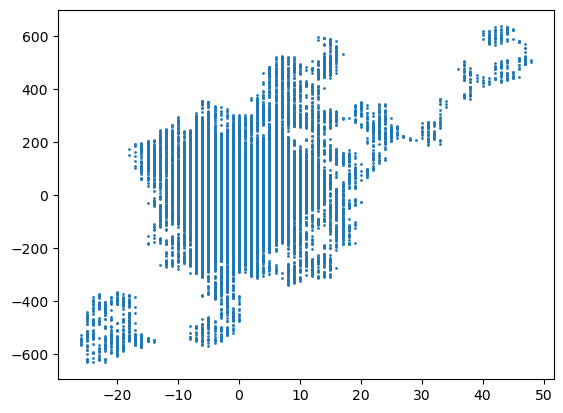

In [19]:
diff = 500
plt.scatter(pair_df["dol"].diff(diff), -1 * pair_df["gear"].diff(-diff), s=1)

### gear trade info

,time,gear,dol,dol_change,dol_sign,gear_change
7992,799200,98563.0,3028.0,0.0,0.0,-4.0
7993,799300,98575.0,3029.0,1.0,1.0,12.0
7994,799400,98575.0,3029.0,0.0,0.0,0.0
7995,799500,98575.0,3029.0,0.0,0.0,0.0
7996,799600,98571.5,3030.0,1.0,1.0,-3.5
7997,799700,98573.0,3039.0,9.0,1.0,1.5
7998,799800,98570.0,3039.0,0.0,0.0,-3.0
7999,799900,98564.5,3039.0,0.0,0.0,-5.5
8000,800000,98564.5,3039.0,0.0,0.0,0.0
8001,800100,98559.5,3039.0,0.0,0.0,-5.0


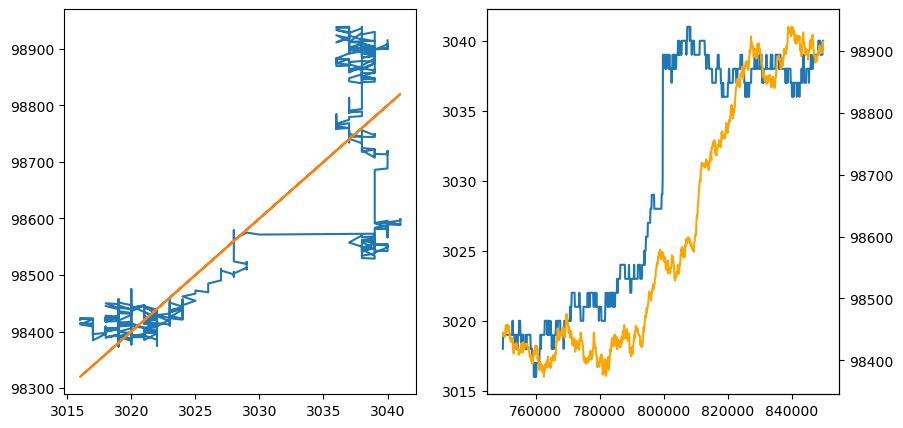

In [20]:
# plot single event

ind = 7997
df = pair_df.loc[ind-500:ind+500]

display(pair_df.loc[ind-5:ind+5])

plt.figure(figsize=(10, 5))

plt.subplot(121)
# scatter dol/gear 
plt.plot(df["dol"], df["gear"])
plt.plot(df["dol"], df["dol"] * 20 + 38000)

# plot dol/gear over time
plt.subplot(122)
ax = plt.gca()
ax.plot(df["time"], df["dol"])

ax2 = ax.twinx()
ax2.plot(df["time"], df["gear"], color="orange", )


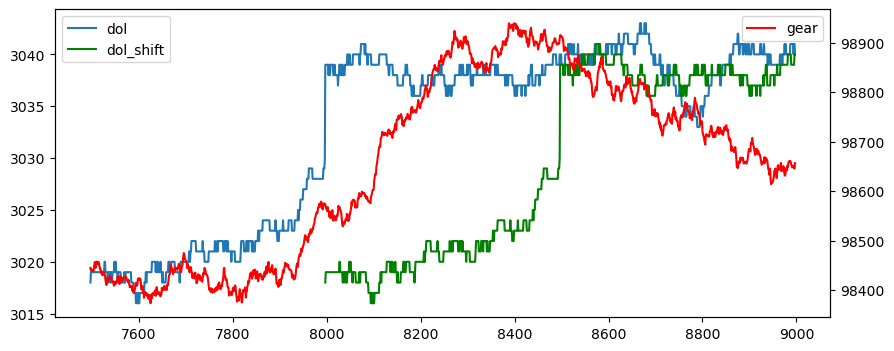

In [21]:
# find good offset
shift = 500

plt.figure(figsize=(10, 4))

ind = 7997
df = pair_df.loc[ind-500:ind+1000].copy()
df["dol_shift"] = df["dol"].shift(shift)

# plot dol/gear over time
ax = plt.gca()
ax.plot(df.index, df["dol"], label="dol")
ax.plot(df.index, df["dol_shift"], color="green", label="dol_shift")

ax2 = ax.twinx()
ax2.plot(df.index, df["gear"], color="red", label="gear")

ax.legend(loc=2)
ax2.legend(loc=1)

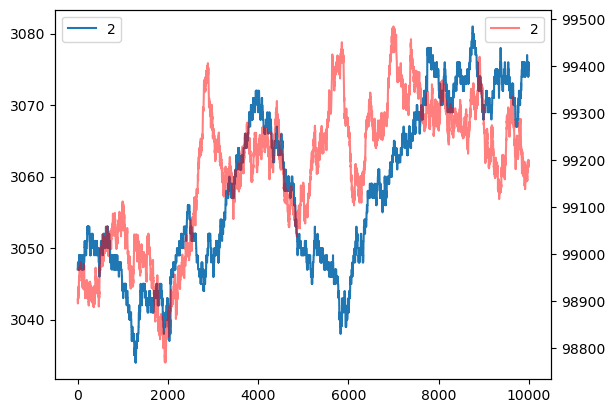

In [22]:
ax = plt.gca()

# ax.plot(np.arange(10000), pair_df["dol"].loc[:10000-1], label=1)
ax.plot(np.arange(10000), pair_df["dol"].loc[10000:20000-1], label=2)
# ax.plot(np.arange(10000), pair_df["dol"].loc[20000:], label=3)

ax2 = ax.twinx()

# ax2.plot(np.arange(10000), pair_df["gear"].loc[:10000-1], label=1, color="red")
ax2.plot(np.arange(10000), pair_df["gear"].loc[10000:20000-1], label=2, color="red", alpha=0.5)
# ax2.plot(np.arange(10000), pair_df["gear"].loc[20000:], label=3, color="red")

ax.legend(loc=2)
ax2.legend(loc=1)


In [23]:
def get_merged_data(x, y):
    inds = x.index.intersection(y.index)
    return x.loc[inds], y.loc[inds]

## past Dol Change -> future Gear change

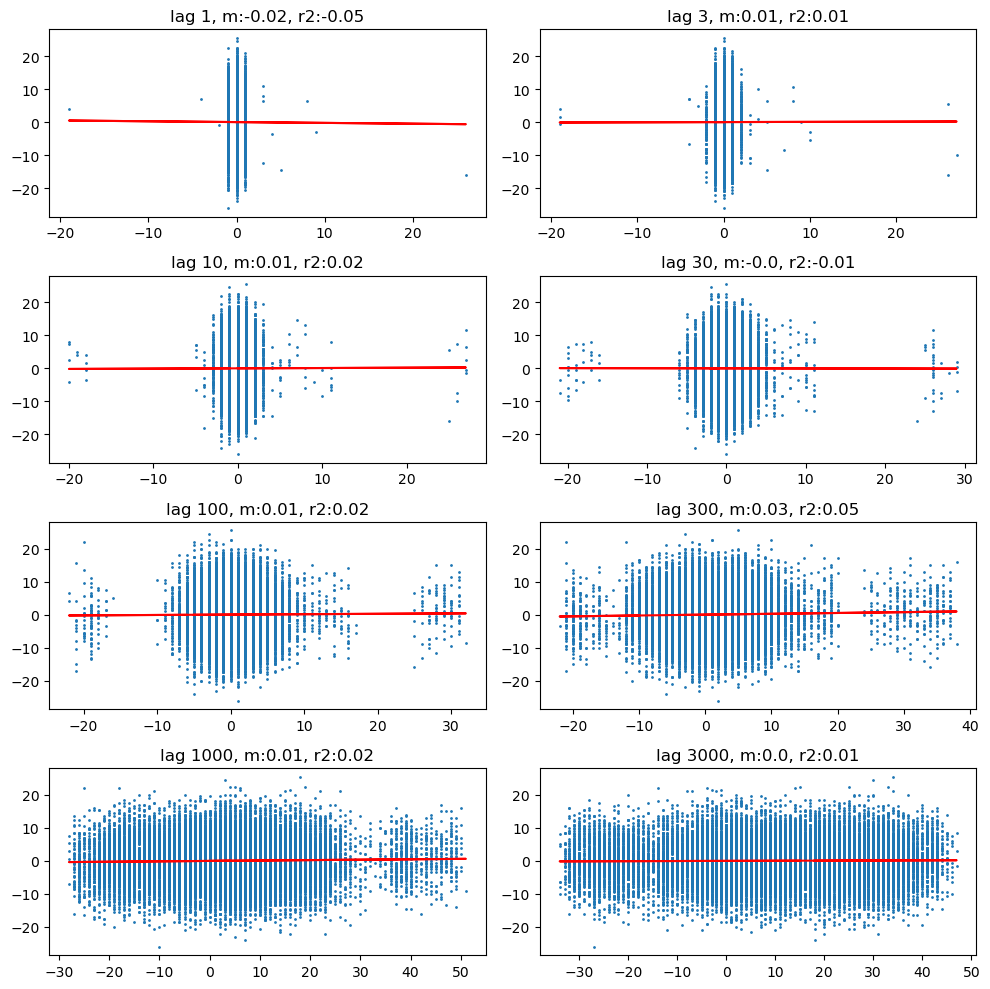

In [24]:
diffs = [1, 3, 10, 30, 100, 300, 1000, 3000]

plt.figure(figsize=(10, 10))

model_data = []

for index, lag in enumerate(diffs):
    x = pair_df["dol"].diff(lag).dropna()
    y = -1 * pair_df["gear"].diff(-1 * 1).dropna()
    x, y = get_merged_data(x, y)

    model = np.poly1d(np.polyfit(x, y, deg=1))
    
    score = round(r2_score(y, model(y)), 2)
    
    model_data += [{
        "m": model.coef[0],
        "b": model.coef[1],
        "r2": score,
    }]
    
    plt.subplot(4, 2, index + 1)
    plt.scatter(x, y, s=1)
    plt.plot(x, model(x), color="red")
    plt.title(f"lag {lag}, m:{round(model.coef[0], 2)}, r2:{score}")
    
plt.tight_layout()
plt.show()

model_df = pd.DataFrame(model_data)

### Lin Reg: dol_cur, gear_cur -> gear_next

In [25]:
from sklearn.linear_model import LinearRegression

model 1 [-0.00032483  0.00617351] 13.417648168327046
r2 0.0006808828905148223


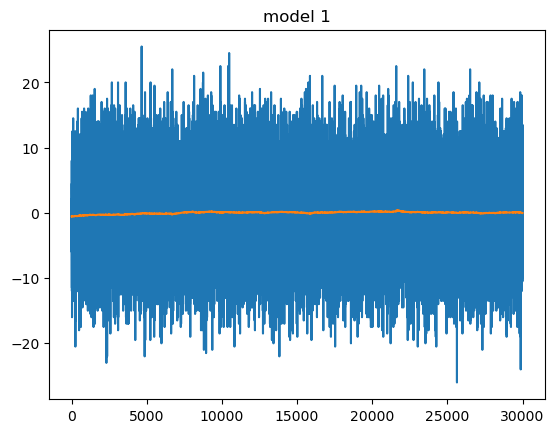

model 3 [-0.00097756  0.01856141] 40.433669160841646
r2 0.0020428791704270033


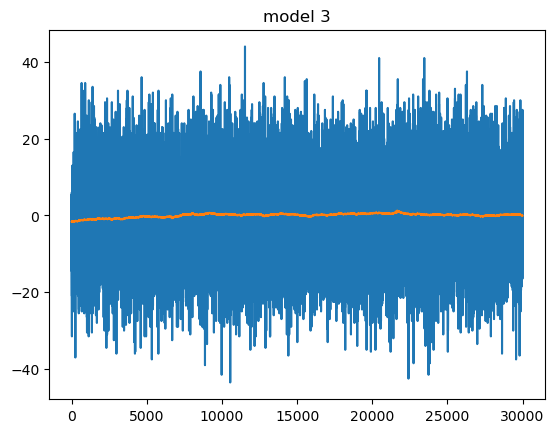

model 10 [-0.00331023  0.06187449] 139.90385021115497
r2 0.006639082809683616


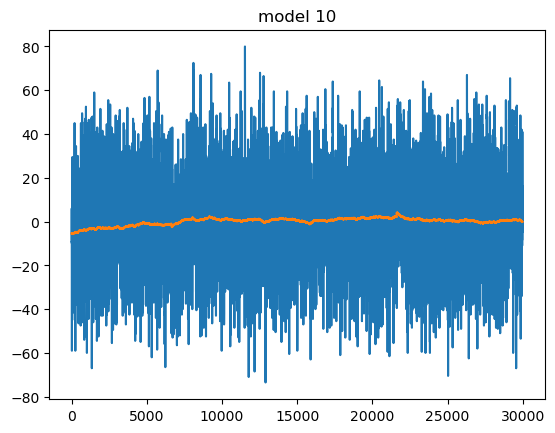

model 30 [-0.01003477  0.18423937] 434.2970687229088
r2 0.01895702629845697


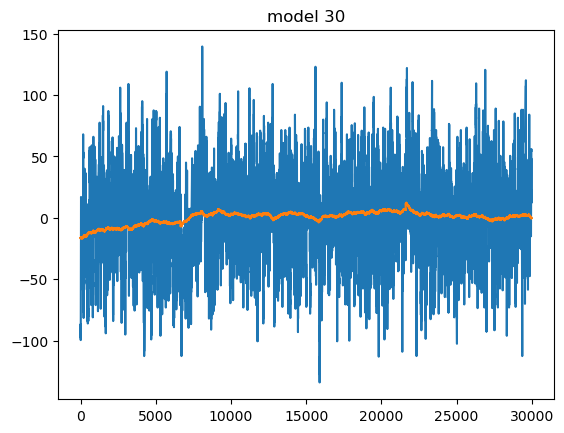

model 100 [-0.03309629  0.5956561 ] 1469.1318514412278
r2 0.05794589066761646


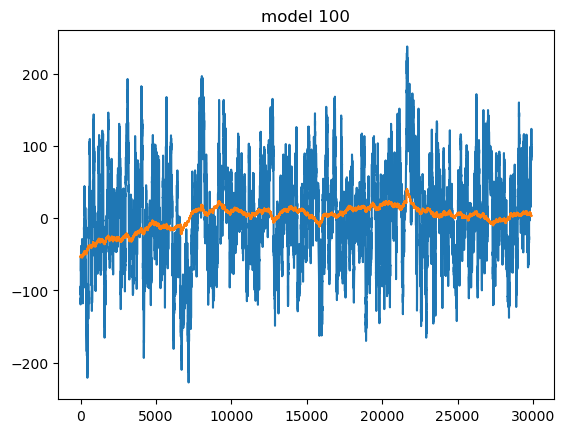

model 300 [-0.10307452  1.6124576 ] 5317.645547638926
r2 0.12168359141831497


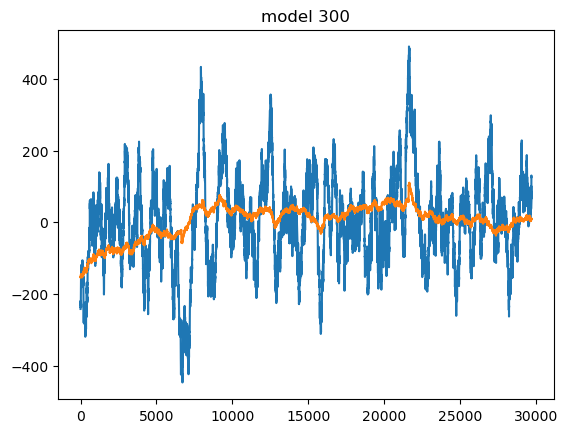

model 500 [-0.17062967  2.40340862] 9616.282008456083
r2 0.15787221836353393


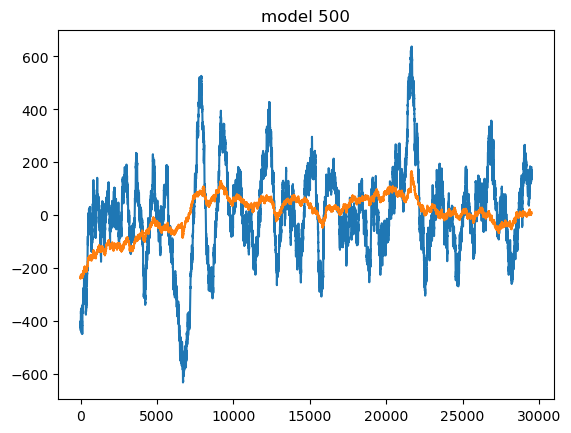

In [26]:
# use current dolphin price and current gear price to predict next gear price

try_turns = [1, 3, 10, 30, 100, 300, 500]
# try_turns = [1, 3, 10, 30, 100, 300, 1000, 1500, 2000, 3000, 5000, 10000, 20000]

for forecast_amt in try_turns:
    pair_df["gear_next"] = -1 * pair_df["gear"].diff(-1 * forecast_amt)

    # only keep non-nan points
    df = pair_df.dropna()
    X = df[["gear", "dol"]]
    y = df["gear_next"]

    # fit the model and print results
    reg = LinearRegression().fit(X, y)
    print("model", forecast_amt, reg.coef_, reg.intercept_)
    print("r2", reg.score(X, y))
    
    plt.plot(y)
    plt.plot(reg.predict(X))
    
    plt.title(f"model {forecast_amt}")
    plt.show()

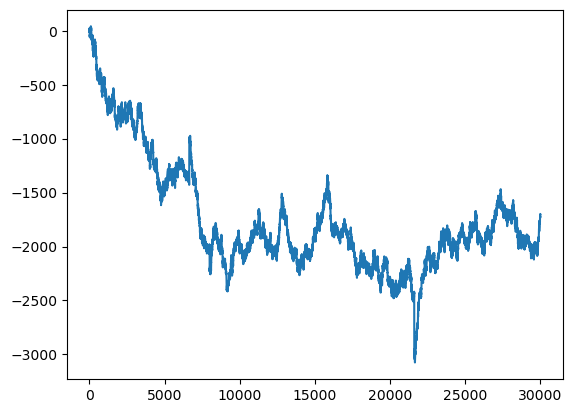

In [27]:
error = plt.plot(pair_df["gear"] - (20 * pair_df["dol"] + 40000))


l1_err 126.80557058882384
mse 26176.210924582338


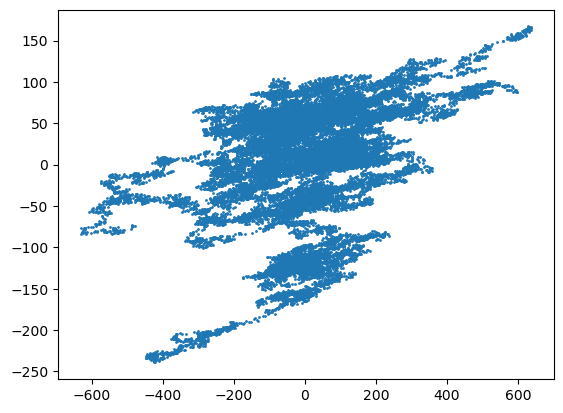

In [28]:
# make results df
res_df = pd.DataFrame({
    "pred": reg.predict(X),
    "y": y,
})

res_df["error"] = res_df["y"] - res_df["pred"]

abs_l1_err = np.mean(res_df["error"].abs())
mse = np.mean(res_df["error"] ** 2)
print("l1_err", abs_l1_err)
print("mse", mse)

# plot results
plt.scatter(res_df["y"], res_df["pred"], s=1)


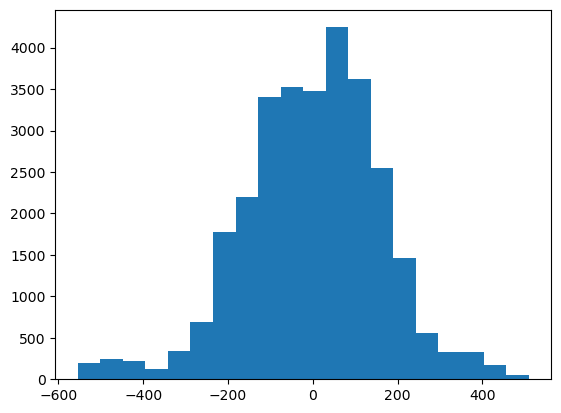

In [29]:
plt.hist(res_df["error"], bins=20)
plt.show()

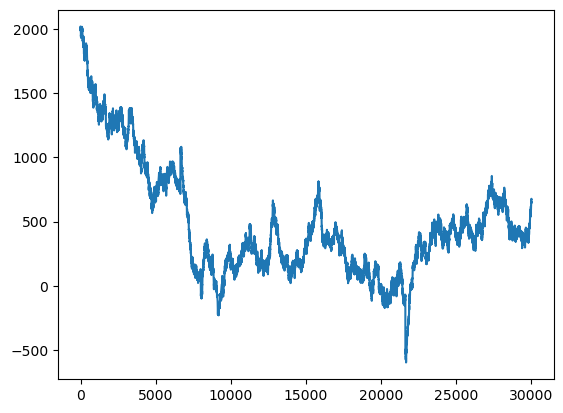

In [30]:
error = pair_df["gear"] - (16 * pair_df["dol"] + 50000)
plt.plot(error)

In [31]:
check_stationary(error)

ADF Statistic: -3.468050
p-value: 0.008847
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


### time lagged cross correlation

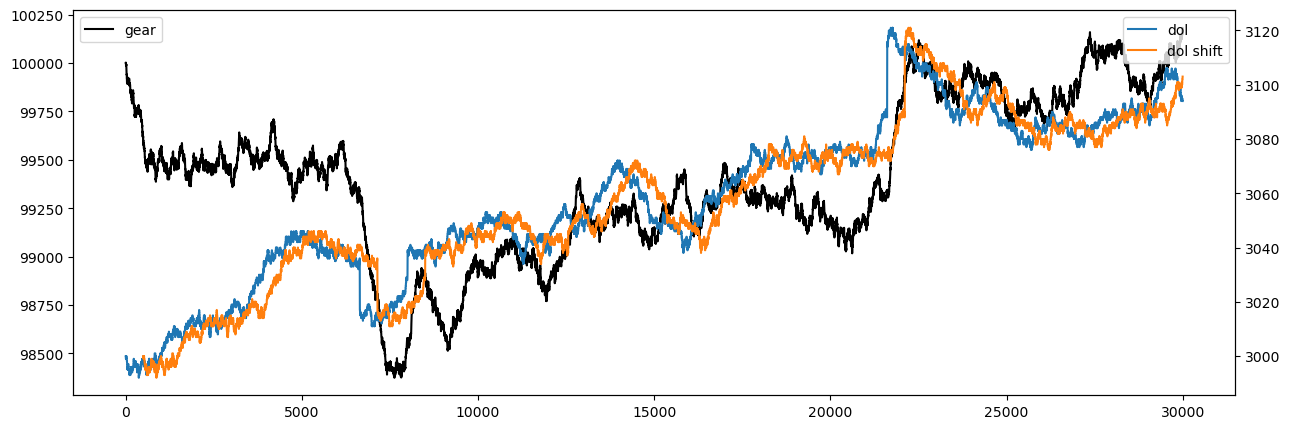

In [32]:
plt.figure(figsize=(15, 5))

ax = plt.gca()
ax.plot(pair_df["gear"], label="gear", color="black")
ax2 = ax.twinx()
ax2.plot(pair_df["dol"], label="dol")
ax2.plot(pair_df["dol"].shift(500), label="dol shift")

ax.legend(loc=2)
ax2.legend(loc=1)


In [33]:
lag_df = pair_df[["time", "gear", "dol"]].copy()

lags = {f"dol_{i}": lag_df["dol"].shift(i) for i in range(0, 500)}

lag_df = pd.DataFrame(lags)
lag_df["time"] = pair_df["time"]
lag_df["gear"] = pair_df["gear"]


In [34]:
corrs = []

for i in range(2000):
    corr = pair_df["dol"].shift(i).corr(lag_df["gear"])
    corrs += [{
        "lag": i,
        "corr": corr,
    }]
    
df = pd.DataFrame(corrs)


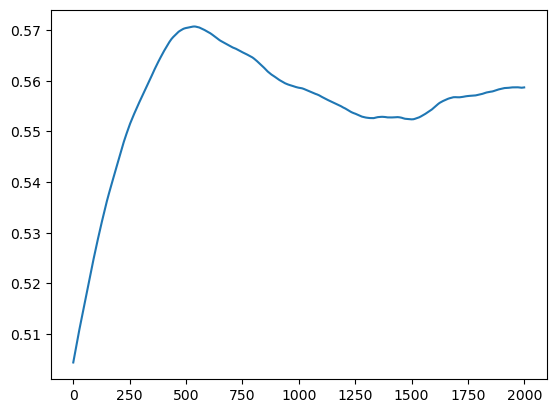

In [35]:
plt.plot(df["corr"])

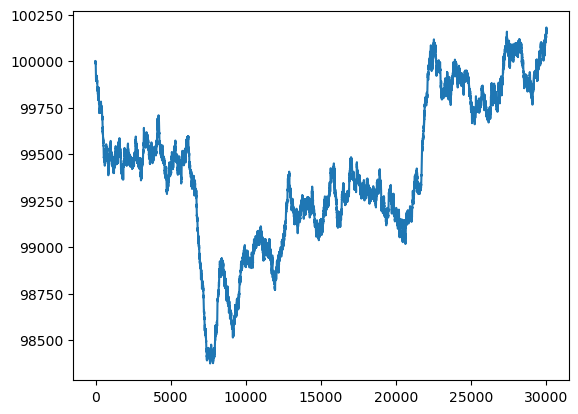

In [36]:
plt.plot(pair_df["gear"])

In [37]:
diffs = pair_df.iloc[5000:10000]["gear"].diff(1)

data = []

chunk_size = 20
for i in range(len(pair_df) // chunk_size):
    lb = i * chunk_size
    ub = lb + chunk_size
    

    data += [{"diff10": np.mean(diffs.loc[lb:ub])}]

In [38]:
models = []
chunk_size = 100

for i in range(len(pair_df) - chunk_size):
    lb = i
    ub = i + chunk_size
    
    df = pair_df["gear"].iloc[lb:ub]
    
    model = np.poly1d(np.polyfit(np.arange(len(df)), df, deg=1))
    models += [{
        "m": model.coef[0],
        "b": model.coef[1],
    }]
    

In [39]:
model_df = pd.DataFrame(models)

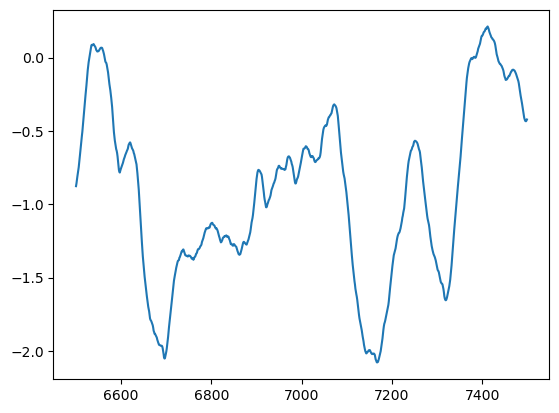

In [40]:
plt.plot(model_df["m"].iloc[6500:7500])

(array([ 2.,  6.,  9.,  9., 15., 17., 28., 35., 29., 26., 34., 13., 12.,
         6.,  4.,  3.,  0.,  0.,  1.,  0.,  1.]),
 array([-3.71428571, -3.27437642, -2.83446712, -2.39455782, -1.95464853,
        -1.51473923, -1.07482993, -0.63492063, -0.19501134,  0.24489796,
         0.68480726,  1.12471655,  1.56462585,  2.00453515,  2.44444444,
         2.88435374,  3.32426304,  3.76417234,  4.20408163,  4.64399093,
         5.08390023,  5.52380952]),
 <BarContainer object of 21 artists>)

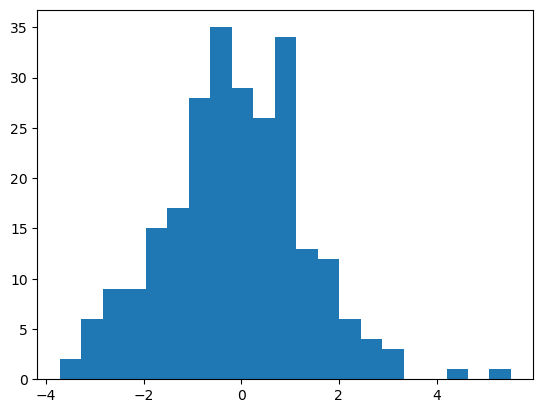

In [41]:
plt.hist(pd.DataFrame(data), bins=21)

(array([   7.,   38.,  107.,  341.,  736., 1428., 2186., 3168., 4403.,
        4463., 4253., 3568., 2452., 1491.,  771.,  369.,  137.,   52.,
          15.,    5.]),
 array([-73.5  , -65.825, -58.15 , -50.475, -42.8  , -35.125, -27.45 ,
        -19.775, -12.1  ,  -4.425,   3.25 ,  10.925,  18.6  ,  26.275,
         33.95 ,  41.625,  49.3  ,  56.975,  64.65 ,  72.325,  80.   ]),
 <BarContainer object of 20 artists>)

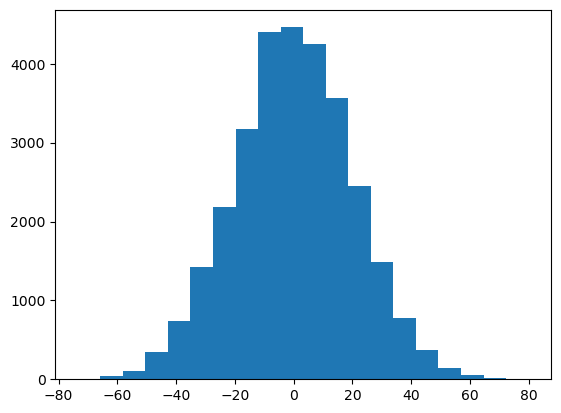

In [42]:
diff10 = pair_df["gear"].diff(10)

plt.hist(diff10, bins=20)

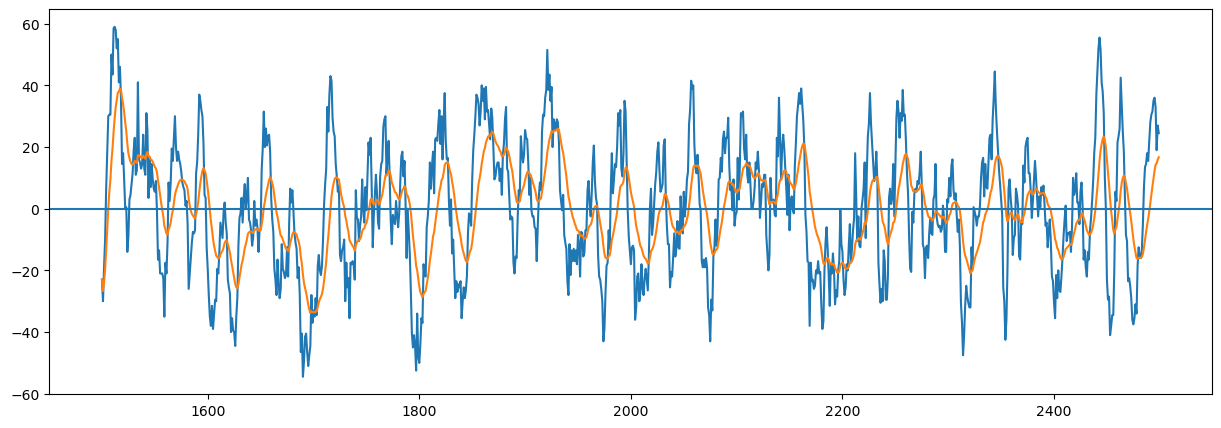

In [43]:
plt.figure(figsize=(15, 5))
plt.plot(diff10.iloc[1500:2500])
plt.plot(diff10.iloc[1500:2500].ewm(span=20).mean())
plt.axhline()

<AxesSubplot:>

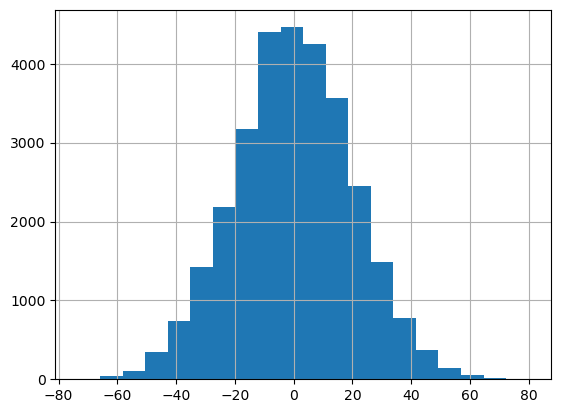

In [44]:
diff10.hist(bins=20)

In [45]:
diffs = 500

X = pair_df[["dol"]].diff(500).dropna()
y = -1 * pair_df["gear"].diff(-1 * 500).dropna()

X, y = get_merged_data(X, y)

reg = LinearRegression().fit(X, y)

In [46]:
reg.score(X, y)

0.1683689206292297

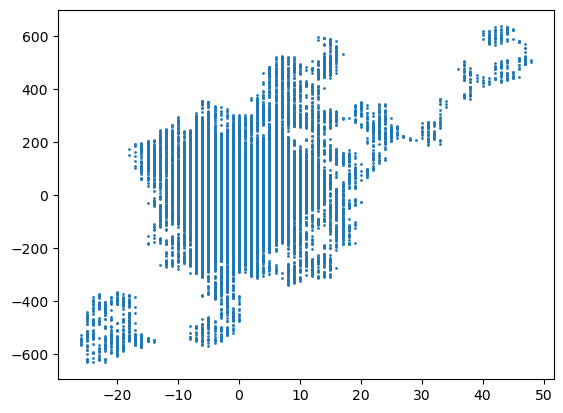

In [47]:
plt.scatter(X, y, s=1)

## berries

In [48]:
berry_df = get_symbol_prices("BERRIES", _day_range)
trade_df = get_symbol_trades("BERRIES", _day_range)
quote_df = get_whale_quotes(berry_df)

trade_df = trade_df.merge(quote_df[["mid_price", "time"]], on="time")


fname ../data/round3/prices_round_3_day_0.csv
fname ../data/round3/prices_round_3_day_1.csv
fname ../data/round3/prices_round_3_day_2.csv
fname ../data/round3/trades_round_3_day_0_nn.csv
fname ../data/round3/trades_round_3_day_1_nn.csv
fname ../data/round3/trades_round_3_day_2_nn.csv


In [50]:
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid_price"]

berry_df["take_buy_edge"] = berry_df["buy_price_1"] - berry_df["mid_price"]
berry_df["take_sell_edge"] = berry_df["mid_price"] - berry_df["sell_price_1"]


(array([  3.,  11., 664., 102.,   0.,   0.,  19.,  13.,  75.,   0.,  10.,
         25.,   0.,   0.,   0.,   1., 136., 675.,  25.,   5.]),
 array([-4.5 , -4.05, -3.6 , -3.15, -2.7 , -2.25, -1.8 , -1.35, -0.9 ,
        -0.45,  0.  ,  0.45,  0.9 ,  1.35,  1.8 ,  2.25,  2.7 ,  3.15,
         3.6 ,  4.05,  4.5 ]),
 <BarContainer object of 20 artists>)

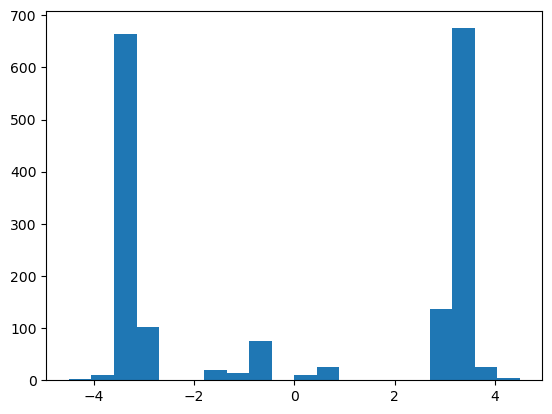

In [140]:
plt.hist(trade_df["sell_edge"], bins=20)

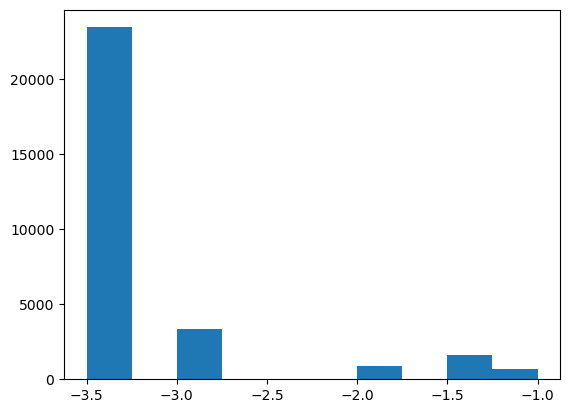

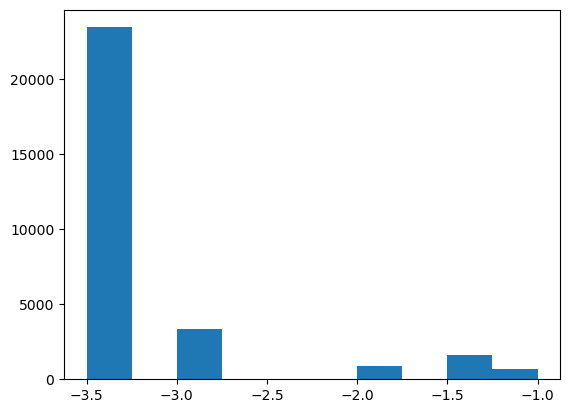

In [51]:
plt.hist(berry_df["take_buy_edge"])
plt.show()

plt.hist(berry_df["take_sell_edge"])
plt.show()

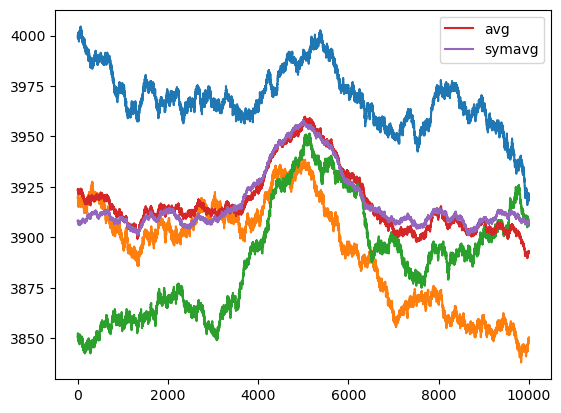

In [104]:
prices = berry_df["mid_price"]

prices = pd.DataFrame({
    "day1": prices.iloc[:10000].values, 
    "day2": prices.iloc[10000:20000].values, 
    "day3": prices.iloc[20000:].values, 
})

prices["avg"] = prices[["day1", "day2", "day3"]].mean(axis=1)
prices["symavg"] = (prices["avg"] + prices["avg"].to_numpy()[::-1]) / 2

plt.plot(prices["day1"])
plt.plot(prices["day2"])
plt.plot(prices["day3"])
plt.plot(prices["avg"], label="avg")
plt.plot(prices["symavg"], label="symavg")

plt.legend()


In [137]:
prices[(prices.reset_index()["index"] - 5000).abs() < 2500].sort_values(by="symavg", ascending=True).iloc[:20]

,day1,day2,day3,avg,symavg
2513,3964.5,3905.5,3861.5,3910.500000,3905.250000
7486,3947.5,3871.0,3881.5,3900.000000,3905.250000
2512,3962.5,3907.5,3861.5,3910.500000,3905.333333
7487,3946.5,3871.5,3882.5,3900.166667,3905.333333
2501,3965.0,3905.5,3866.5,3912.333333,3905.333333
7498,3947.0,3869.5,3878.5,3898.333333,3905.333333
2514,3965.0,3904.5,3860.5,3910.000000,3905.416667
7488,3949.5,3868.0,3882.5,3900.000000,3905.416667
2511,3965.5,3905.5,3861.5,3910.833333,3905.416667
7485,3948.5,3871.5,3882.5,3900.833333,3905.416667


In [98]:
prices

,day1,day2,day3,avg
0,4000.0,3919.5,3850.5,3923.333333
1,3999.5,3919.5,3850.5,3923.166667
2,3998.5,3919.5,3852.5,3923.500000
3,3998.5,3919.5,3851.5,3923.166667
4,3999.5,3920.5,3852.0,3924.000000
...,...,...,...,...
9995,3920.5,3850.0,3905.5,3892.000000
9996,3922.0,3850.0,3907.5,3893.166667
9997,3920.5,3850.5,3907.5,3892.833333
9998,3918.0,3850.5,3907.5,3892.000000


(array([ 14., 766.,   0.,  32.,  75.,  35.,   0.,   1., 811.,  30.]),
 array([-4.5, -3.6, -2.7, -1.8, -0.9,  0. ,  0.9,  1.8,  2.7,  3.6,  4.5]),
 <BarContainer object of 10 artists>)

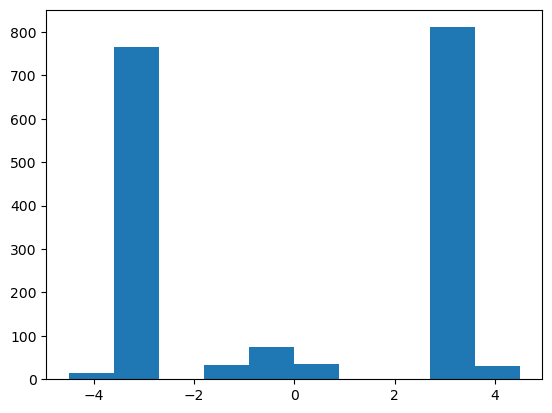

In [54]:
plt.hist(trade_df["sell_edge"])